## Analyze rates_delay_loss made by test_env.py
ex. all traces (train one by one)

In [8]:
import pandas as pd
import numpy as np
from plot_cdf import plot_cdf, plot_cdf_multiple
import matplotlib.pyplot as plt
import json
import os
import glob

In [9]:
# conf_name = "SAC_train_traces_one_by_one_v6" #during training, test each trace after having trained on it
conf_name = "SAC_all_traces_1_env_v6" #after training on all, do test_env.py first with "./data/SAC_all_traces_1_env_v6/5.zip", then take a look

In [39]:
reward_profile = 4
conf_name = f"SAC_WIRED_900kbps_200_delay_False_norm_states_True_tuned_True_reward_profile_{reward_profile}"

In [40]:
prefix = "../output/rates_delay_loss_"
suffix = ".pickle"

pickle_path = prefix+conf_name+suffix
print(pickle_path)
l_rate = pd.read_pickle(pickle_path)
time_step = 200
print(time_step)

../output/rates_delay_loss_SAC_WIRED_900kbps_200_delay_False_norm_states_True_tuned_True_reward_profile_4.pickle
200


In [41]:
l_rate.keys()

dict_keys(['./traces/WIRED_900kbps.json', './traces/WIRED_200kbps.json'])

Trace: ./traces/WIRED_900kbps.json


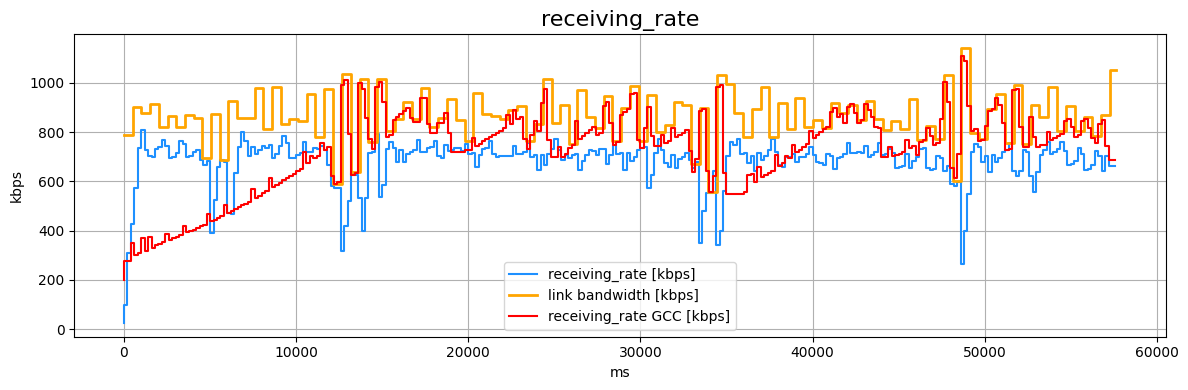

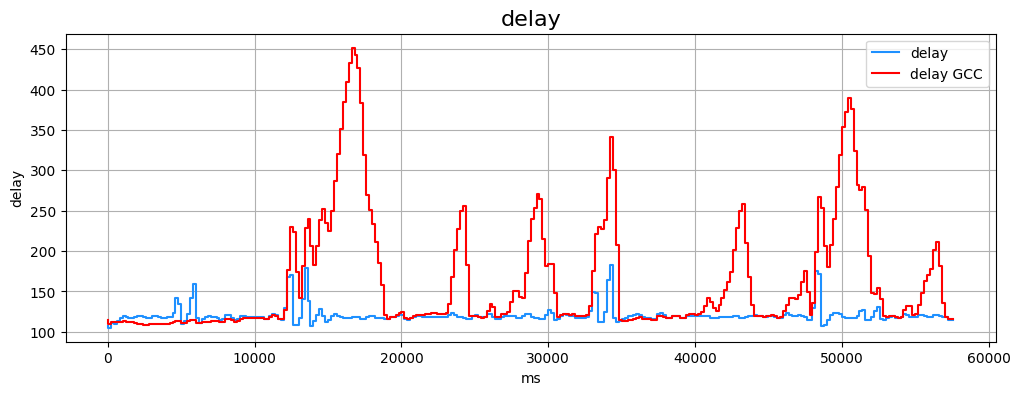

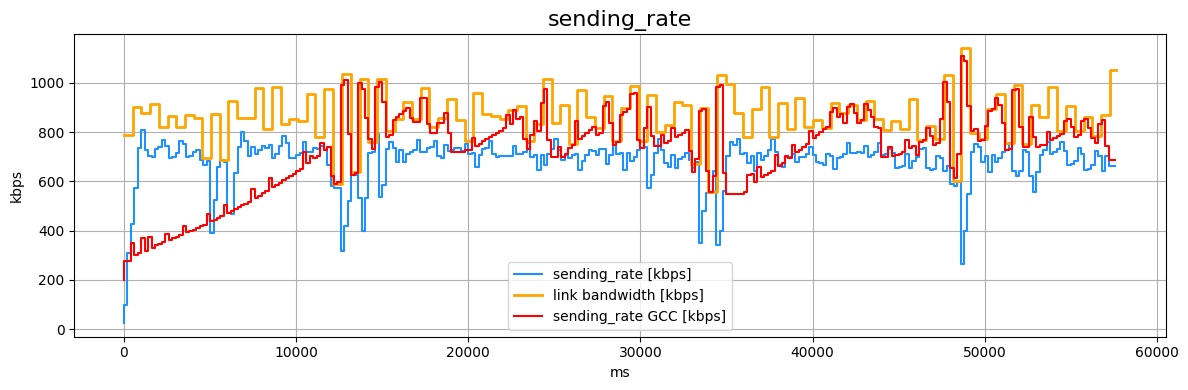

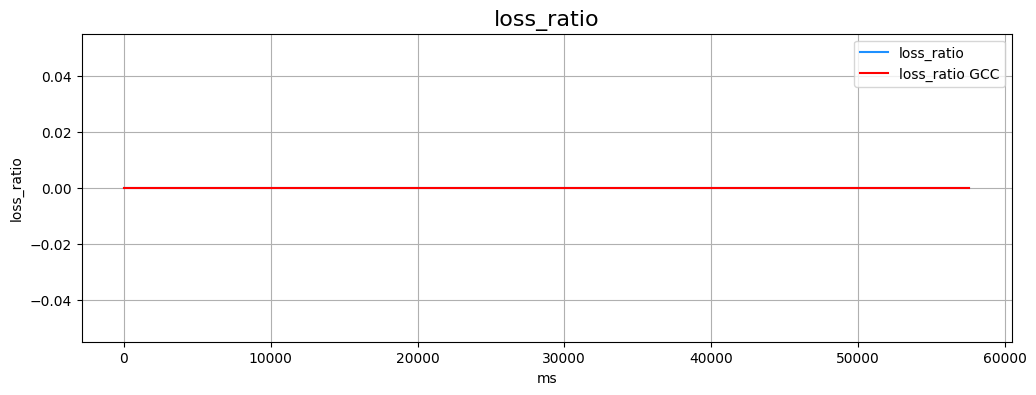

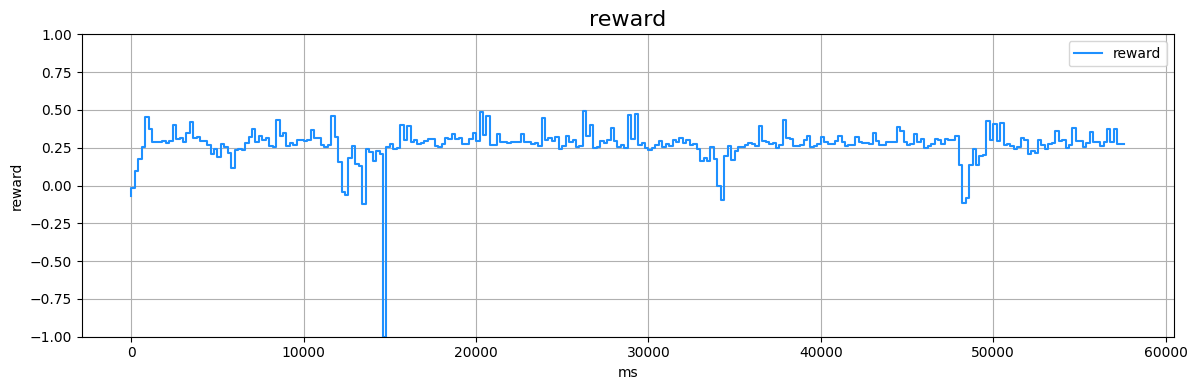



Trace: ./traces/WIRED_200kbps.json


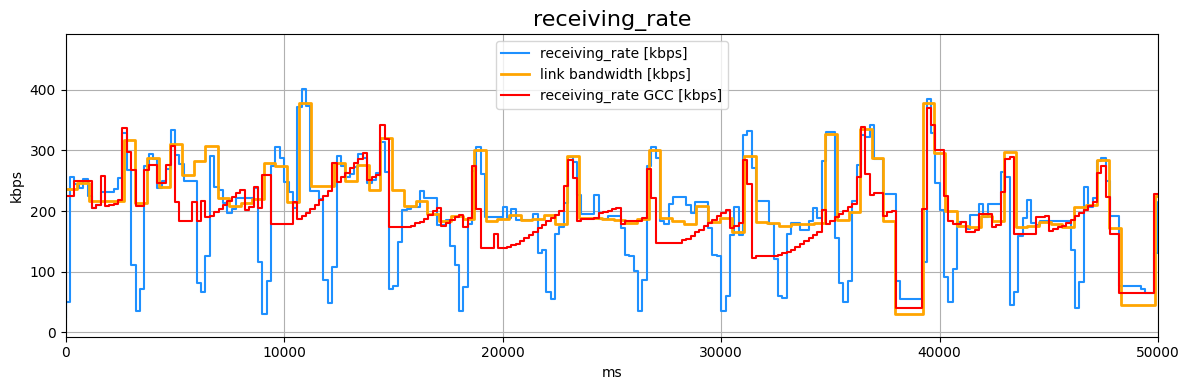

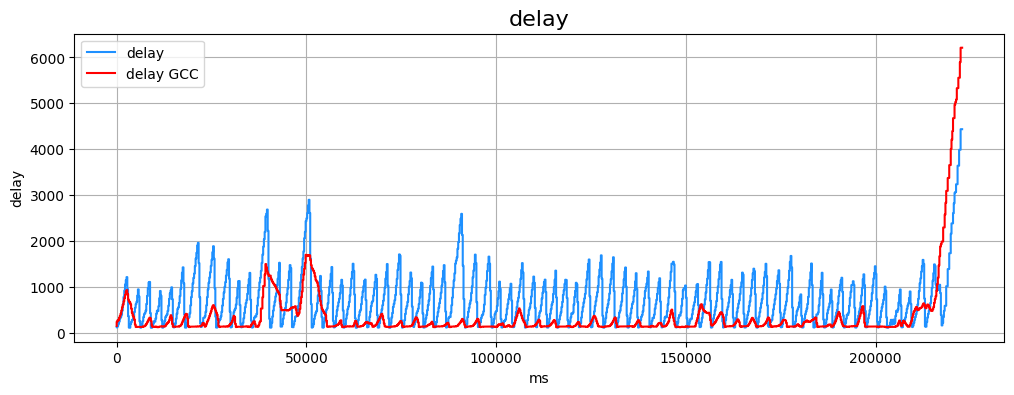

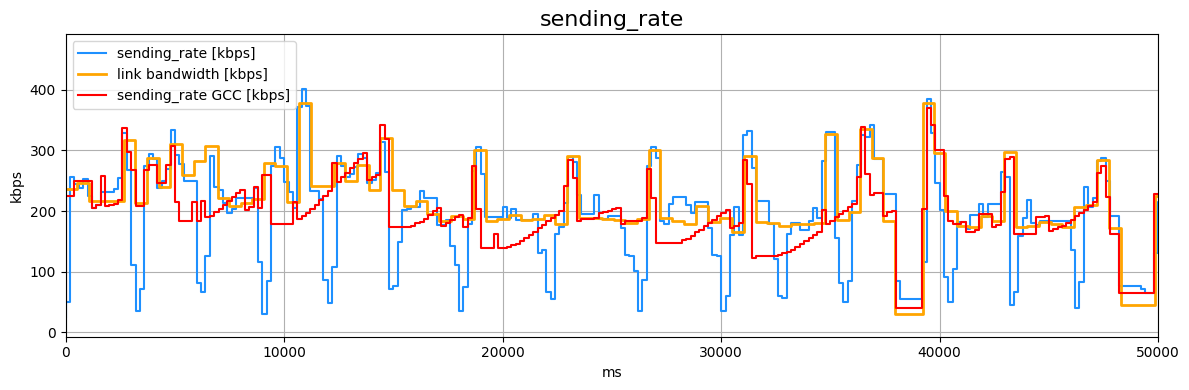

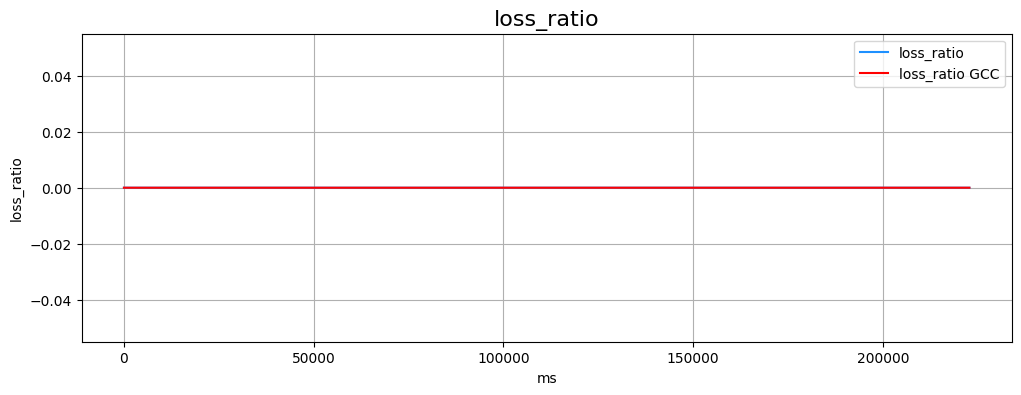

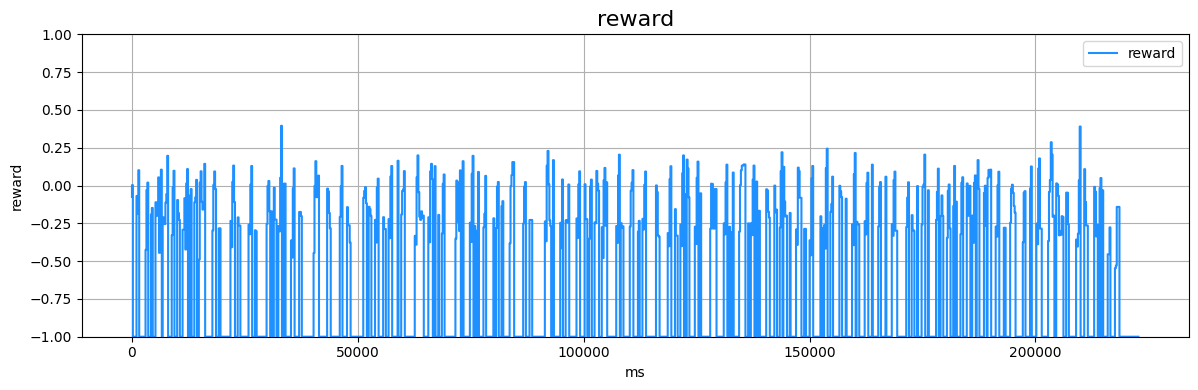

In [43]:
plot_gcc = True

for key in l_rate.keys():
    
    print(f"Trace: {key}")
    colors = iter(["dodgerblue", "teal", "indianred", "olive", "yellow", "green"])

    # for metric in ["bandwidth_prediction", "receiving_rate", "sending_rate", "delay", "loss_ratio", "reward"]:
    for metric in ["receiving_rate", "delay", "sending_rate", "loss_ratio", "reward"]: #reward
        #Define capacity

        trace_name = "../" + key.split("/")[1] + "/" + key.split("/")[2]
        REAL_NAME = key.split("/")[2].split(".")[0]
        
        pickle_path_gcc = f"../apply_model/results_gcc/rates_delay_loss_gcc_{REAL_NAME}.pickle"
        l_rate_gcc = pd.read_pickle(pickle_path_gcc)
        
        if l_rate_gcc["trace_name"] != REAL_NAME:
            print("Trace not the same as GCC")

        with open(trace_name, "r") as f:
            d = json.load(f)

        df = pd.DataFrame(d["uplink"]["trace_pattern"])
        time = [0] + list(df["duration"].cumsum())
        capacities = [df["capacity"].iloc[0]] + list(df["capacity"])
        

        df_rate = pd.DataFrame(l_rate[key][metric], columns=[metric])
        if plot_gcc and (metric != "reward"):
            df_rate_gcc = pd.DataFrame(l_rate_gcc[metric], columns=[metric])
            df_rate = df_rate.join(df_rate_gcc, rsuffix="_gcc")

        t = np.arange(len(df_rate))*time_step
        df_rate["time"] = t
        df_rate.set_index("time", inplace=True)


        if metric in ["bandwidth_prediction", "sending_rate", "receiving_rate"]:

            plt.figure(figsize=(12,4))
            plt.title(metric, fontsize=16)
            # color=next(colors)
            plt.step(df_rate.index, df_rate[metric]/1000, label=f"{metric} [kbps]", color="dodgerblue")
            plt.step(time, capacities, lw=2, label="link bandwidth [kbps]", color="orange")
            if plot_gcc and (metric != "reward"):
                plt.step(df_rate.index, df_rate[f"{metric}_gcc"]/1000, label=f"{metric} GCC [kbps]", color="red")
            plt.legend()
            plt.ylabel("kbps")
            plt.xlabel("ms")
            plt.grid()
            if REAL_NAME == "WIRED_200kbps":
                plt.xlim((0, 50000))
            if REAL_NAME == "WIRED_35mbps":
                plt.ylim((0, 40000))
            elif REAL_NAME == "4G_700kbps":
                plt.ylim(0, 1500)
            elif REAL_NAME == "4G_3mbps":
                plt.ylim(0,8000)
            elif REAL_NAME == "4G_500kbps":
                plt.ylim(0,1600)
            plt.tight_layout()

        else:
            plt.figure(figsize=(12,4))
            plt.title(metric, fontsize=16)
            plt.step(df_rate.index, df_rate[metric], label=f"{metric}", color="dodgerblue")
            if plot_gcc and (metric != "reward"):
                plt.step(df_rate.index, df_rate[f"{metric}_gcc"], label=f"{metric} GCC", color="red")
            plt.ylabel(metric)
            plt.xlabel("ms")
            plt.legend()
            plt.grid()
            if metric == "reward":
                plt.tight_layout()
                plt.ylim(-1,1)
                plt.savefig(f"./plots/reward_{REAL_NAME}_{reward_profile}.png")
            
        plt.show()
        print("\n")

## Calculate scores

##### Clip U when it's larger than 0

In [52]:
def make_bandwidth_series(current_trace, step_time):
    #read bandwidth file and create series
    #index timestamps, values bandwidth
    with open(current_trace, "r") as f:
        d = json.load(f)
    df = pd.DataFrame(d["uplink"]["trace_pattern"])
    time = [0] + list(df["duration"].cumsum())
    capacities = [df["capacity"].iloc[0]] + list(df["capacity"])
    s = pd.Series(index=pd.to_datetime(time, unit="ms"), data=capacities)
    capacities = s.resample(f"{step_time}ms").ffill()
    return capacities

In [53]:
current_trace = "../traces/" + REAL_NAME + ".json"
current_trace

'../traces/4G_500kbps.json'

### 1 QoE Utilization - receiving rate

In [55]:
metric = "receiving_rate"

capacities = make_bandwidth_series(current_trace, time_step)

df_rate = pd.DataFrame(l_rate[key][metric], columns=[metric])
df_rate_gcc = pd.DataFrame(l_rate_gcc[metric], columns=[metric])
df_rate = df_rate.join(df_rate_gcc, rsuffix="_gcc")

t = np.arange(len(df_rate))*time_step
df_rate["time"] = t
df_rate["time"] = pd.to_datetime(df_rate["time"], unit="ms")
df_rate.set_index("time", inplace=True)

receiving_rate_kbps = df_rate["receiving_rate"]/1000
capacities_kbps = capacities.replace(0, 100000000)

rr_kbps_gcc = df_rate["receiving_rate_gcc"]/1000

U = receiving_rate_kbps / capacities_kbps
U_gcc = rr_kbps_gcc / capacities_kbps

(0.0, 1.0)

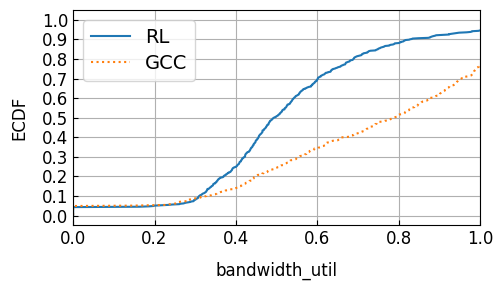

In [57]:
plot_cdf_multiple([U, U_gcc], "bandwidth_util", legend=["RL", "GCC"], figsize=(5,3))
plt.xlim(0,1)

In [58]:
U_gcc.max(), U.max()

(2.410748560460653, 2.7072936660268714)

In [59]:
qoe_rr = 100*U.quantile(0.5)
qoe_rr_gcc = 100*U_gcc.quantile(0.5)
print("QoE receiving rate:")
print(f"RL: {round(qoe_rr,2)}, GCC: {round(qoe_rr_gcc,2)}")

QoE receiving rate:
RL: 49.42, GCC: 78.81


### 2 QoE delay

In [60]:
metric = "delay"

df_rate = pd.DataFrame(l_rate[key][metric], columns=[metric])
df_rate_gcc = pd.DataFrame(l_rate_gcc[metric], columns=[metric])
df_rate = df_rate.join(df_rate_gcc, rsuffix="_gcc")

t = np.arange(len(df_rate))*time_step
df_rate["time"] = t
df_rate["time"] = pd.to_datetime(df_rate["time"], unit="ms")
df_rate.set_index("time", inplace=True)

delay = df_rate["delay"]
delay_gcc = df_rate["delay_gcc"]

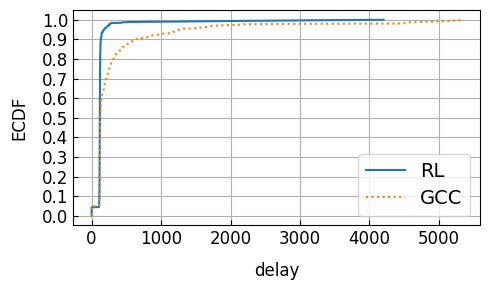

In [61]:
plot_cdf_multiple([delay, delay_gcc], "delay", legend=["RL", "GCC"], figsize=(5,3))
# plt.xlim(0,1)

In [62]:
d_max = delay.max()
d_min = delay.min()
d_95 = delay.quantile(0.95)

d_max_gcc = delay_gcc.max()
d_min_gcc = delay_gcc.min()
d_95_gcc = delay_gcc.quantile(0.95)

In [63]:
#QoE delay has to do with delay variation + magnitude
qoe_delay = 100*(d_max-d_95)/(d_max - d_min)
qoe_delay_gcc = 100*(d_max_gcc - d_95_gcc) / (d_max_gcc - d_min_gcc)

print("QoE delay:")
print(f"RL: {round(qoe_delay,2)}, GCC: {round(qoe_delay_gcc,2)}")

QoE delay:
RL: 95.69, GCC: 76.25


### 3 QoE losses

In [65]:
metric = "loss_ratio"

df_rate = pd.DataFrame(l_rate[key][metric], columns=[metric])
df_rate_gcc = pd.DataFrame(l_rate_gcc[metric], columns=[metric])
df_rate = df_rate.join(df_rate_gcc, rsuffix="_gcc")

t = np.arange(len(df_rate))*time_step
df_rate["time"] = t
df_rate["time"] = pd.to_datetime(df_rate["time"], unit="ms")
df_rate.set_index("time", inplace=True)

loss_ratio = df_rate["loss_ratio"]
loss_ratio_gcc = df_rate["loss_ratio_gcc"]

In [66]:
L = loss_ratio.mean()
L_gcc = loss_ratio_gcc.mean()
L, L_gcc

(0.0, 0.0017364932619169907)

In [67]:
qoe_losses = 100*(1-L)
qoe_losses_gcc = 100*(1-L_gcc)

print("QoE losses:")
print(f"RL: {round(qoe_losses,2)}, GCC: {round(qoe_losses_gcc,2)}")

QoE losses:
RL: 100.0, GCC: 99.83


### 4 Overall QoE

In [68]:
qoe = 0.333*qoe_rr + 0.333*qoe_delay + 0.333*qoe_losses
qoe_gcc = 0.333*qoe_rr_gcc + 0.333*qoe_delay_gcc + 0.333*qoe_losses_gcc

print("Overall QoE:")
print(f"RL: {round(qoe,2)}, GCC: {round(qoe_gcc,2)}")

Overall QoE:
RL: 81.62, GCC: 84.88


In [70]:
#From paper
# qoe2 = 0.2*qoe_rr + 0.2*qoe_delay + 0.3*qoe_losses
# qoe_gcc2 = 0.2*qoe_rr_gcc + 0.2*qoe_delay_gcc + 0.3*qoe_losses_gcc

# print("To compare with HRCC paper: overall QoE:")
# print(f"RL: {qoe2}, GCC: {qoe_gcc2}")